# The affect of Selecting Variable Genes on Deconcolution

In [ ]:
import os
import sys
sys.path.append('..')
import pandas as pd
import scanpy as sc
from TUT import tut

base_dir = "Z:\\MorrissyLab Dropbox\\Visium_profiling\\benchmark"
data_dir = os.path.join(base_dir, "data")
results_dir = tut.process.utils.check_dir(os.path.join(base_dir, "svg_results"))

dataset_list = {
    "Dataset10_STARmap_li2022_sim_norm_mm" : {
        "fig_width": 5,
        "fig_height": 10,
        "ot" : {
            "h" : 0.01,
            "w" : 1e-2,
            "eps": 5e-3,
            "lr": 0.001,
            "optm": "adam",
            "cost": "cosine"
        }
    },
    "Dataset4_seqFISH_li2022_sim_norm_mm" : {
        "fig_width": 10,
        "fig_height": 5,
        "ot" : {
            "h" : 0.01,
            "w" : 1e-2,
            "eps": 5e-3,
            "lr": 0.001,
            "optm": "adam",
            "cost": "cosine"
        }
    },
    "MOB_dance_sim_norm_mm": {
        "fig_width": 10,
        "fig_height": 5,
        "ot" : {
            "h" : 0.01,
            "w" : 1e-2,
            "eps": 5e-3,
            "lr": 0.001,
            "optm": "adam",
            "cost": "cosine"
        },
    },
    "stereoseq_mouse_brain_li2023_sim_norm_mm": {
        "fig_width": 60,
        "fig_height": 65,
        "ot" : {
            "h" : 0.01,
            "w" : 1e-2,
            "eps": 5e-3,
            "lr": 0.001,
            "optm": "adam",
            "cost": "cosine"
        }
    },
}


running_experiments = ["cnmf", "ot", "lda", "nmf"]
running_datasets = dataset_list.keys()

is_spatial = True
for alpha in [0.05]:
    for adjusted in [True]:
        kwargs = {
            'alpha': alpha,
            'use_unadjusted_pvals' : adjusted,
            'is_spatial': is_spatial
        }

        experiment_version = "_".join([f"{key}_{value}" for key, value in kwargs.items()])

        for dataset in running_datasets:
            print(f"Starting {dataset}")

            if(dataset == "stereoseq_mouse_brain_li2023_sim_norm_mm"):
                steroseq_dataset_path = os.path.join(data_dir, dataset)              
                adata_spatial = tut.process.io.get_xeno_spatial_data(steroseq_dataset_path, sample_name=dataset)
            else:
                dataset_path = os.path.join(data_dir, dataset)
                adata_spatial = sc.read_h5ad(os.path.join(dataset_path, "adata_spatial.h5ad"))

            sample_name = adata_spatial.uns["dataset_name"]
            print(sample_name, adata_spatial.X.shape)

            adata_spatial.uns["params"]=dataset_list[dataset]

            """Run experiments and annotations for a given adata."""
            for exp_name in running_experiments:
                print(sample_name, exp_name)
                k = len(adata_spatial.uns["ground_truth"].columns) 
                tut.run_experiment(adata_spatial.copy(), k, sample_name, exp_name,
                                    results_dir = os.path.join(results_dir, sample_name, experiment_version), filter_genes=True, **kwargs)

                tut.annotate.annotate_with_benchmark(sample_results_dir = os.path.join(results_dir, sample_name, experiment_version), adata_spatial = adata_spatial, exp_name=exp_name, correlation_type = 'cosine', top_n_features = 500)





Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [ ]:

# for dataset in running_datasets:
#     print(f"Starting {dataset}")
#     if(dataset == "stereoseq_mouse_brain_li2023_sim_norm_mm"):
#         steroseq_dataset_path = os.path.join(data_dir, dataset)              
#         adata_spatial = tut.process.io.get_xeno_spatial_data(steroseq_dataset_path, sample_name=dataset)
#     else:
#         dataset_path = os.path.join(data_dir, dataset)
#         adata_spatial = sc.read_h5ad(os.path.join(dataset_path, "adata_spatial.h5ad"))
#     sample_name = adata_spatial.uns["dataset_name"]
#     print(sample_name, adata_spatial.X.shape)
#     adata_spatial.uns["params"]=dataset_list[dataset]


#     results_df = []
#     keys= []
#     for svg_experiment in os.listdir(os.path.join(results_dir, dataset)):
#         for exp_name in running_experiments:
#             r_df = tut.benchmark.benchmark.benchmark_results(
#                         os.path.join(results_dir, dataset, svg_experiment, f"{exp_name}_{dataset}"),
#                         adata_spatial,
#                         sample_name=sample_name,
#                         exp_name=exp_name,
#             )
#             results_df.append(r_df)
#             keys.append(f"{svg_experiment.replace("_use_unadjusted_pvals_","").replace("alse","").replace("rue","")}_{exp_name}")
#     dfs = pd.concat(results_df, keys=keys, names=["experiment", "celltype"])
#     dfs.to_csv(os.path.join(results_dir, dataset, f"metrics_{dataset}.csv"), header=True)

## Analysis of selecting variable genes

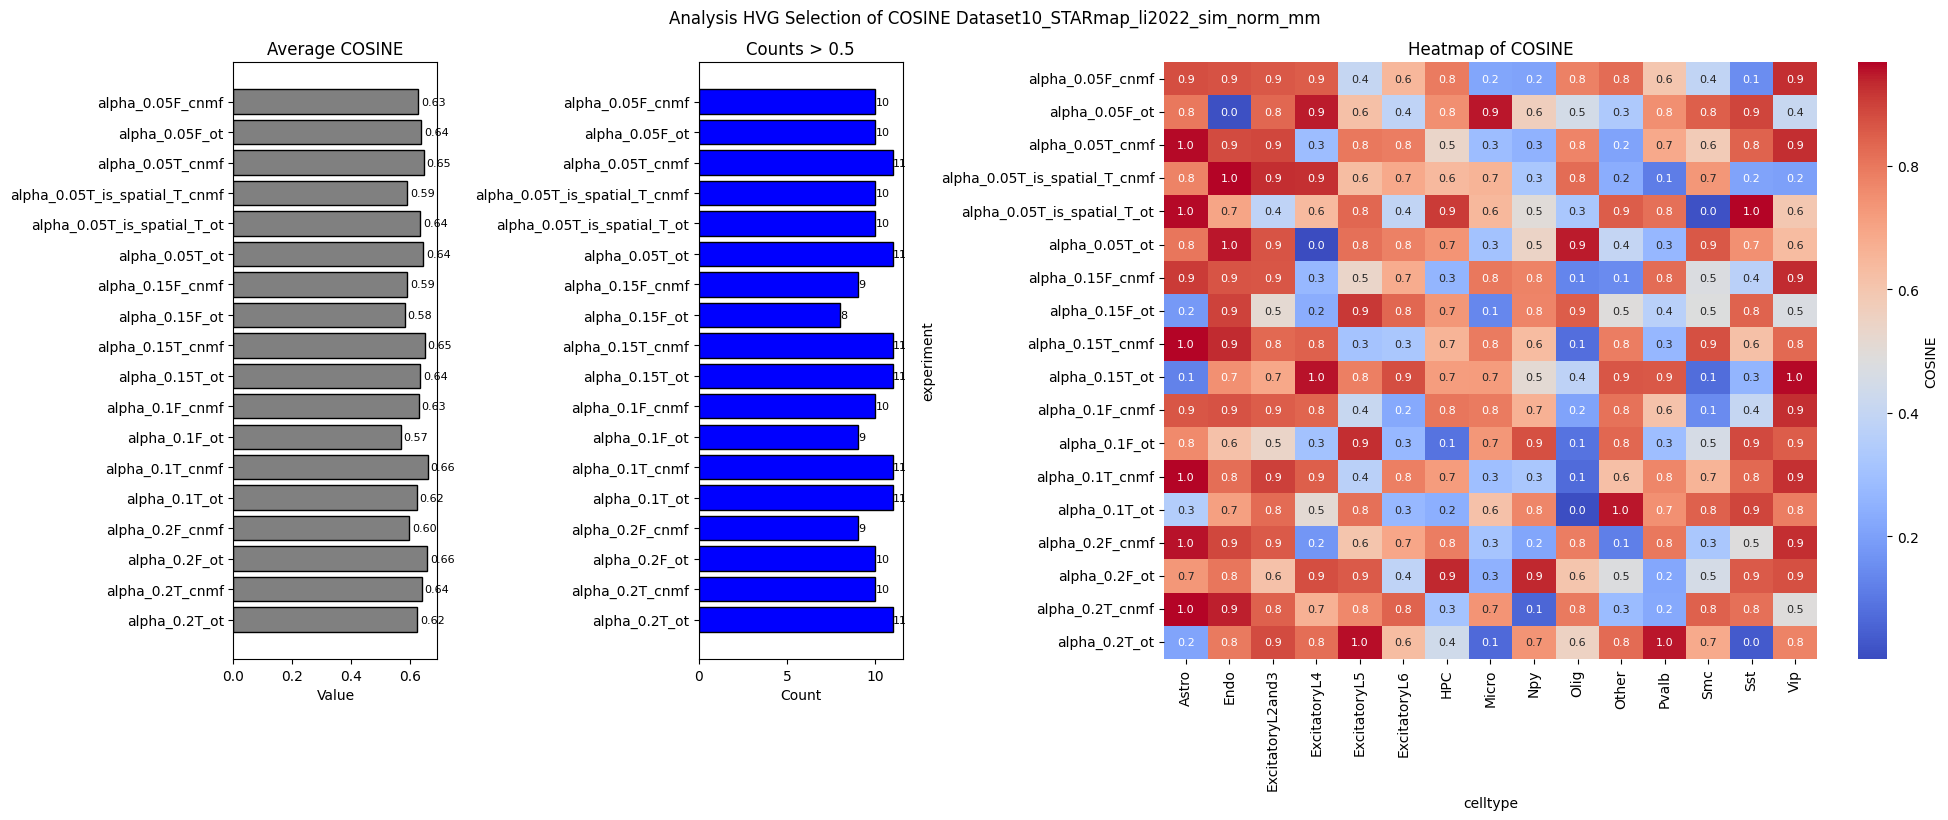

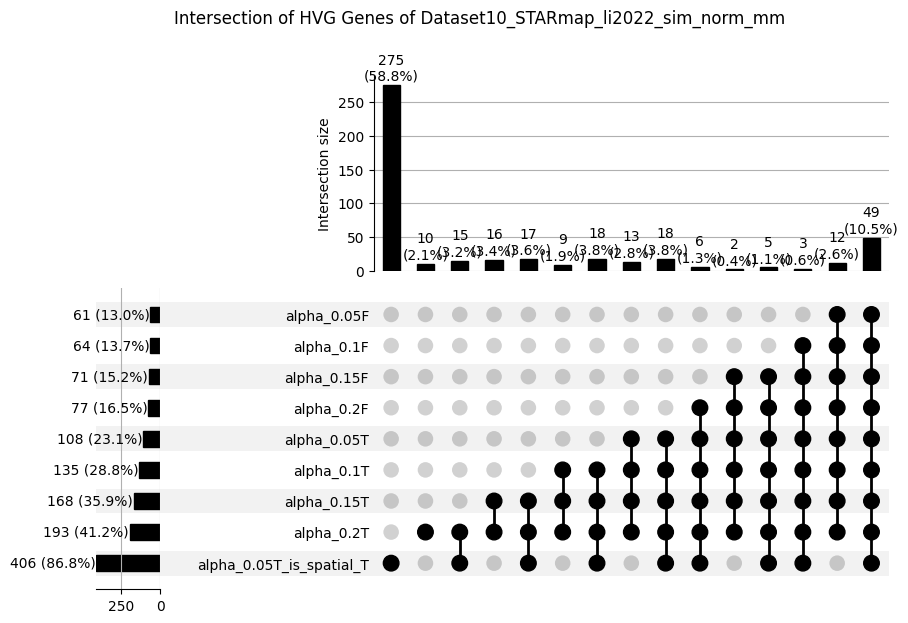

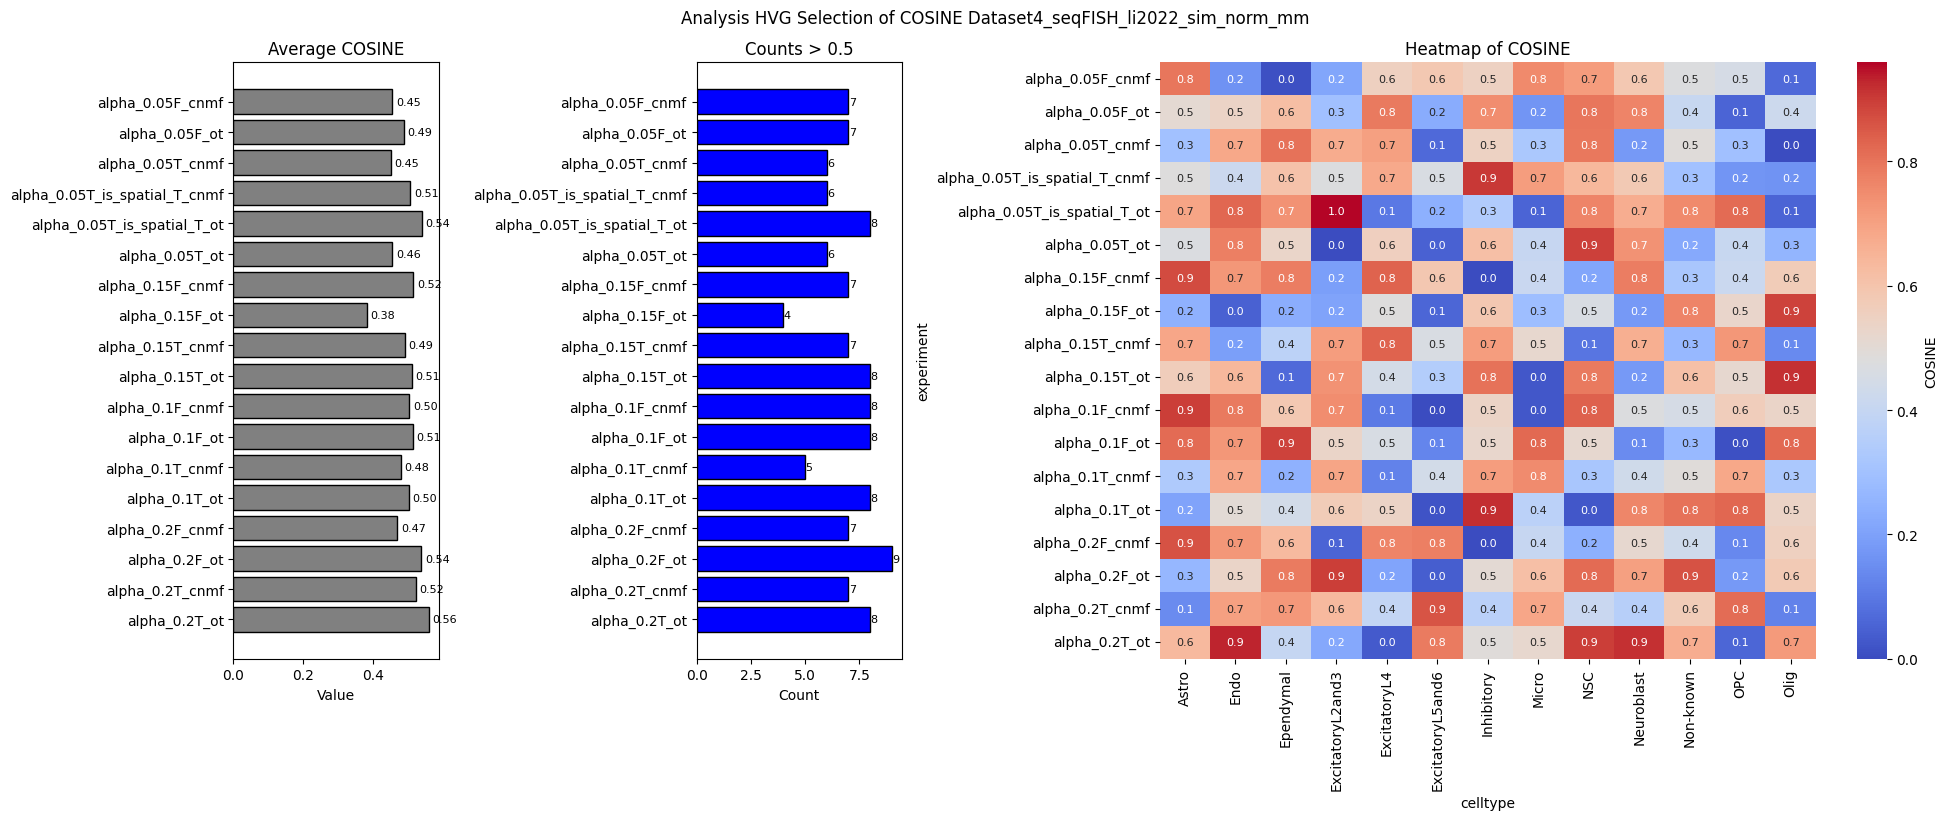

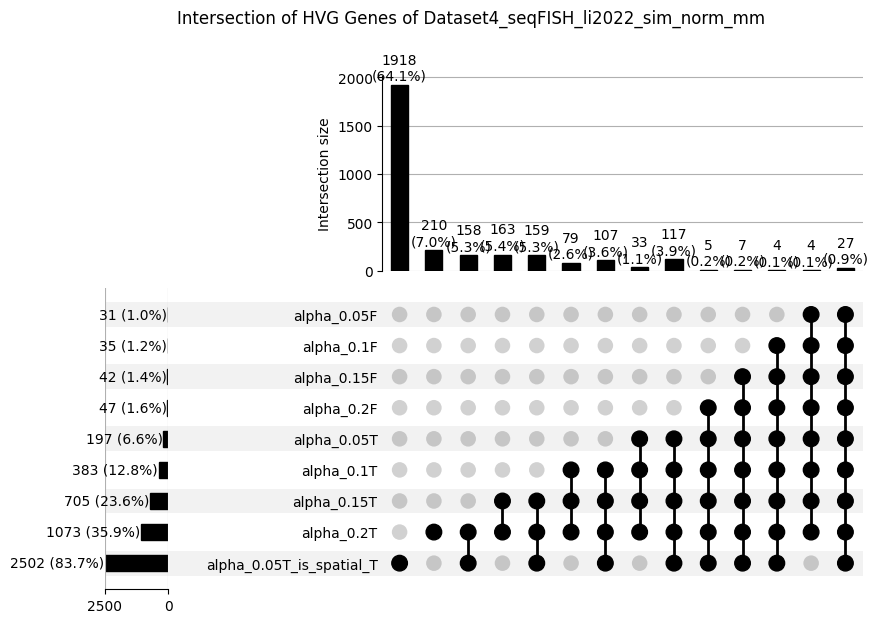

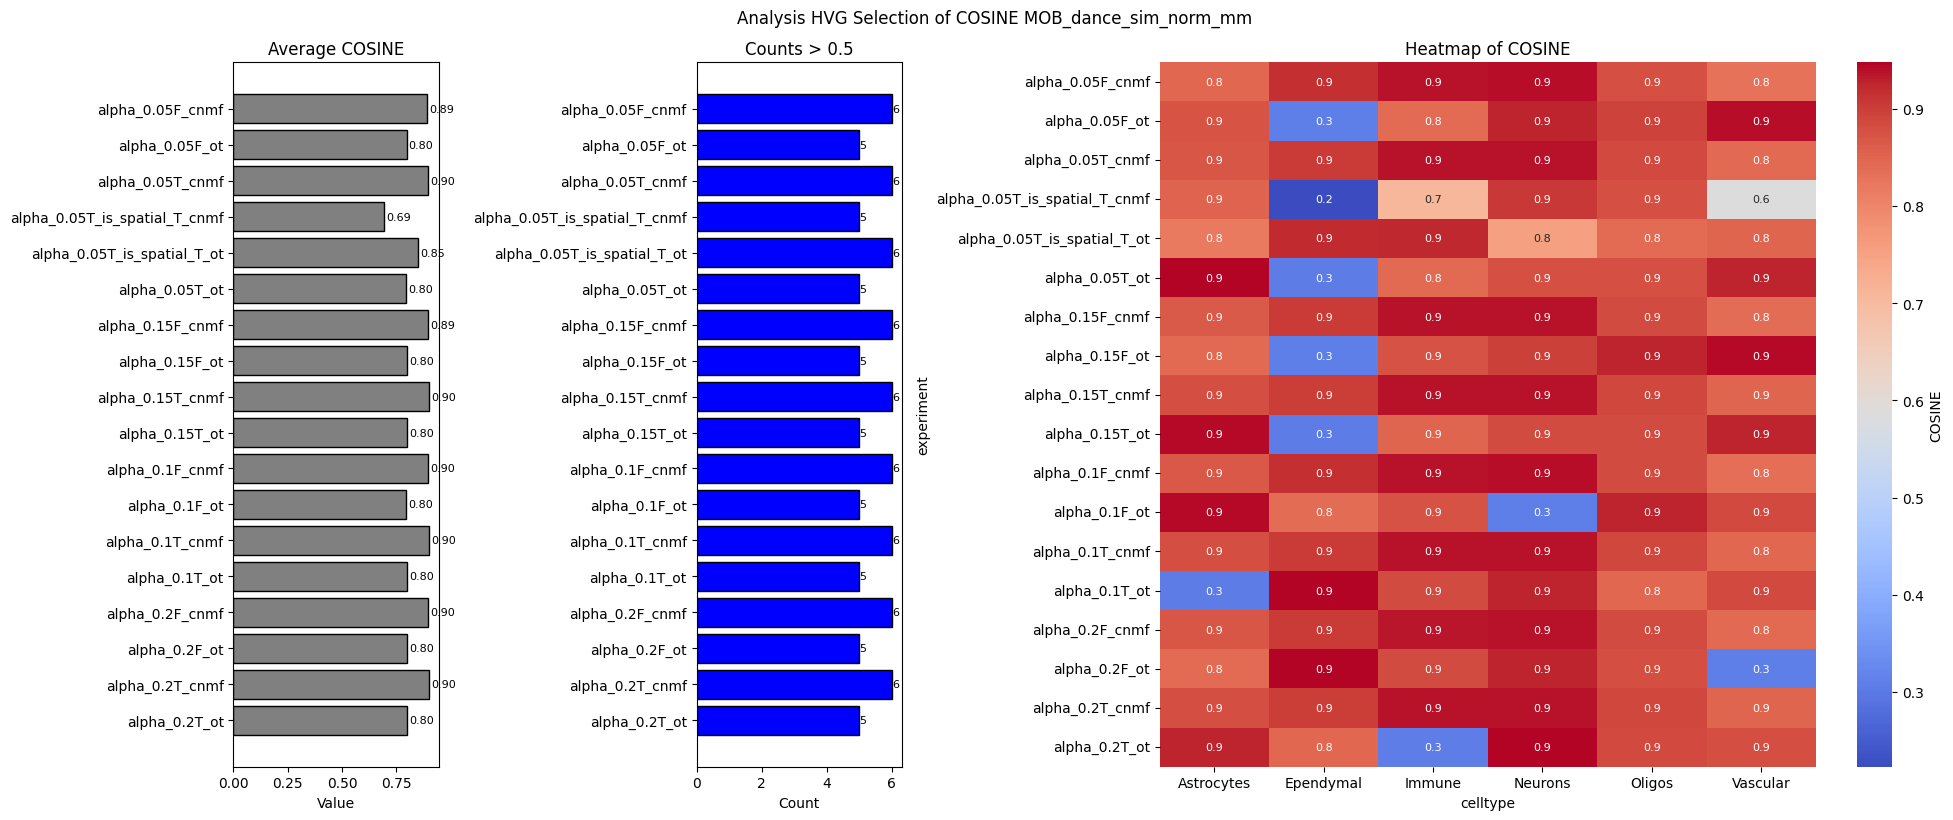

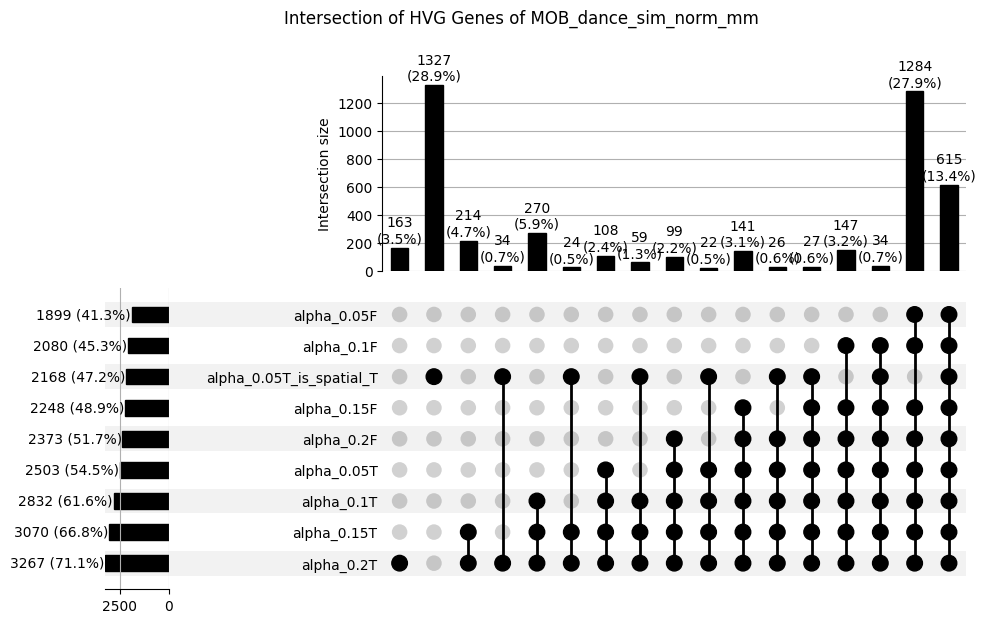

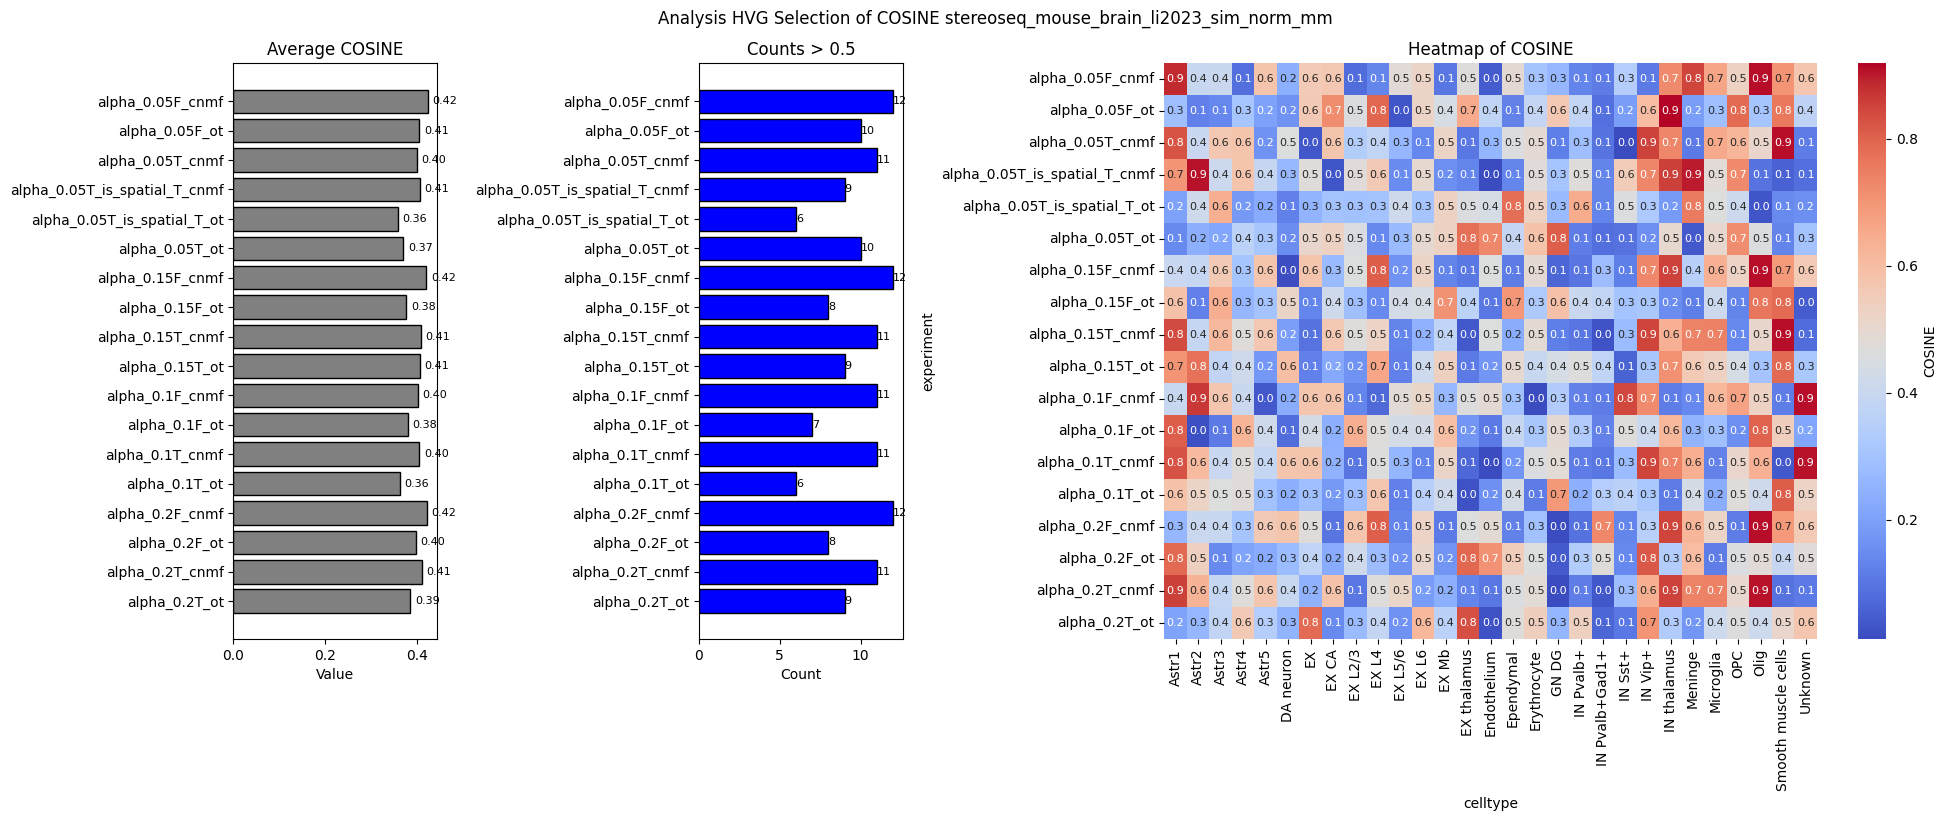

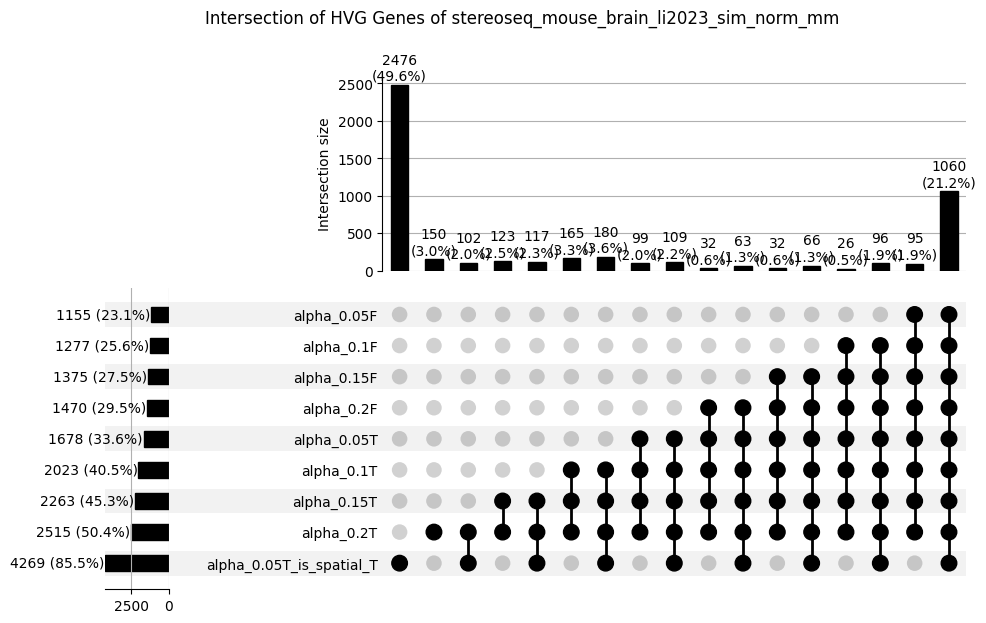

In [ ]:
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
from upsetplot import from_contents, UpSet

for dataset in running_datasets:
    dfs = pd.read_csv(os.path.join(results_dir, dataset, f"metrics_ot_{dataset}.csv"))

    data_genes = {}
    for svg_experiment in os.listdir(os.path.join(results_dir, dataset)):
        experiment_path = os.path.join(results_dir, dataset, svg_experiment, f"ot_{dataset}")
        if(os.path.isdir(experiment_path)):
            df_genes = pd.read_csv(os.path.join(experiment_path, f"gene_stats_ot_{dataset}.csv"),index_col=0)
            data_genes[f"{svg_experiment.replace("_use_unadjusted_pvals_","").replace("alse","").replace("rue","")}"] = df_genes[df_genes['is_odg'] == True].index.values.tolist()
            
    metric = "COSINE"

    # Pivot the DataFrame to create a matrix format for the heatmap
    heatmap_data = dfs.pivot(index="experiment", columns="celltype", values=metric)
    row_averages = heatmap_data.mean(axis=1)
    row_counts_above_threshold = (heatmap_data > 0.5).sum(axis=1)
    fig, axes = plt.subplots(1, 3, figsize=(20, 8), gridspec_kw={'width_ratios': [1, 1, 4]})
    axes[0].barh(row_averages.index, row_averages, color='gray', edgecolor='black', height=0.8)
    axes[0].set_title(f"Average {metric}")
    axes[0].set_xlabel("Value")
    axes[0].invert_yaxis()
    for i, val in enumerate(row_averages):
        axes[0].text(val + 0.01, i, f"{val:.2f}", va='center', fontsize=8)

    # Plot 2: Bar plot of counts of values > 0.5
    axes[1].barh(row_counts_above_threshold.index, row_counts_above_threshold, color='blue', edgecolor='black', height=0.8)
    axes[1].set_title(f"Counts > 0.5")
    axes[1].set_xlabel("Count")
    axes[1].invert_yaxis()
    for i, val in enumerate(row_counts_above_threshold):
        axes[1].text(val + 0.01, i, f"{val:.0f}", va='center', fontsize=8)

    # Plot 3: Heatmap
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".1f",
        cmap="coolwarm",
        cbar_kws={'label': metric},
        annot_kws={"size": 8},
        ax=axes[2]
    )
    axes[2].set_title(f"Heatmap of {metric}")


    # Adjust layout and show
    plt.tight_layout()
    fig.suptitle(f"Analysis HVG Selection of {metric} {dataset}", y=1.02)
    fig.savefig(os.path.join(results_dir, dataset, f"heatmap_metrics_{dataset}.pdf"))
    plt.show()

    # Create UpSet plot
    fig = plt.figure(figsize=(10, 8))
    upset_data = from_contents(data_genes)
    upset = UpSet(upset_data, show_counts="%d", show_percentages=True)
    fig.suptitle(f"Intersection of HVG Genes of {dataset}")
    upset.plot(fig)
    fig.savefig(os.path.join(results_dir, dataset, f"upset_hvg_{dataset}.pdf"))
    plt.show()



In [26]:
# # Prepare data for visualization

# import numpy as np
# from skimage.metrics import structural_similarity as ssim
# from skimage.metrics import mean_squared_error
# from math import sqrt
# from scipy.spatial.distance import jensenshannon
# from scipy.stats import pearsonr, ttest_ind, mannwhitneyu
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd
# import distinctipy
# from scipy.stats import rankdata
# import matplotlib.lines as mlines


# df_melted = dfs.reset_index().melt(id_vars=['experiment', 'celltype'], var_name='metric', value_name='Value')
# unique_metrics = df_melted['metric'].unique()
# unique_experiments = df_melted["experiment"].unique()

# # Generate a distinct color palette for experiments
# palette = distinctipy.get_colors(len(unique_experiments), rng=0)
# palette_dict = dict(zip(unique_experiments, palette))

# # Plotting Boxplots and AS Barplot (First Figure)
# fig, axes = plt.subplots(2, 5, figsize=(20, 20))
# axes = axes.flatten()

# for i, metric in enumerate(unique_metrics):
#     ax = axes[i]

#     sns.boxplot(data=df_melted[df_melted['metric'] == metric], x='Value', y='experiment',
#                 hue='experiment', palette=palette_dict, ax=ax, showmeans=True, orient="h",
#                  legend=False)
#     ax.set_title(metric)
#     ax.set_ylabel('Experiment')
#     ax.set_xlabel(metric)

# fig.suptitle(sample_name)
# plt.tight_layout()
# # plt.savefig(os.path.join(results_dir_path, f"plot_metrics_{sample_name}.pdf"))
# plt.show()


In [27]:
# # Melt the dataframe to a long format
# df_melted = dfs.reset_index().melt(
#     id_vars=["experiment", "celltype"],
#     value_vars=["PCC", "SSIM", "RMSE", "JS"],
#     var_name="metric",
#     value_name="value"
# )

# # Define offsets, colors, and marker styles for each metric
# metric_offsets = {"PCC": -0.4, "SSIM": -0.2, "RMSE": 0, "JS": 0.2, "AS_S": 0.4}
# metric_colors = {"PCC": "Blues", "SSIM": "Reds", "RMSE": "Purples", "JS": "Oranges", "AS_S": "Greys"}
# metric_markers = {"PCC": "o", "SSIM": "s", "RMSE": "p", "JS": "D", "AS_S": "^"}

# # Map x-position to cell types and apply offsets for each metric
# spacing_factor = 1.5
# df_melted['x_position'] = (
#     df_melted['celltype'].astype('category').cat.codes * spacing_factor +
#     df_melted['metric'].map(metric_offsets)
# )

# # Initialize the plot
# plt.figure(figsize=(30, 20))
# for metric in df_melted['metric'].unique():
#     subset = df_melted[df_melted['metric'] == metric]
#     plt.scatter(
#         subset['x_position'], subset['experiment'],
#         c=subset['value'], s=50, cmap=plt.get_cmap(metric_colors[metric]),
#         label=metric, marker=metric_markers[metric]
#     )

# # Customize the x-axis to show cell types in the center of each group
# unique_celltypes = dfs.reset_index()['celltype'].unique()
# tick_positions = np.linspace(
#     df_melted['x_position'].min() + 0.4,
#     df_melted['x_position'].max() - 0.4,
#     len(unique_celltypes)
# )
# plt.xticks(ticks=tick_positions, labels=unique_celltypes, rotation=90)

# # Add axis labels and a title
# plt.xlabel("Cell Type")
# plt.ylabel("Experiment")
# plt.title(f"Dot Plot {sample_name}")

# # Define colors for each metric legend
# metric_colors_legend = {
#     "PCC": plt.cm.Blues(0.9),
#     "SSIM": plt.cm.Reds(0.9),
#     "RMSE": plt.cm.Purples(0.9),
#     "JS": plt.cm.Oranges(0.9)
# }
# legend_handles = [
#     mlines.Line2D(
#         [0], [0], color='w', label=metric, marker=metric_markers[metric],
#         markerfacecolor=metric_colors_legend[metric], markersize=10
#     ) for metric in metric_colors_legend
# ]

# # Add custom legend
# plt.legend(handles=legend_handles, title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')

# # Adjust layout and show plot
# plt.tight_layout()
# plt.show()